# Introduction or Motivation or Problem Statement
We are trying to train a facial recognition neural network. To be able to identify people in pictures 
with the people inside a database.


# Data Sources
The data used for training can be found at:
AT&T dataset - https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip 
(gray-scaled dataset with 400 samples)
lfw dataset - https://www.kaggle.com/datasets/atulanandjha/lfwpeople
(colored dataset with 13000+ images)


# Exploratory Data Analysis
Each class in the dataset is a person's name with 10 grey pictures of their portrait.
For data preparation the image transformed to size 100 x 100 to fit the model and changed into grey pictures and then turned into 1x100x100 tensor.
In SiameseNetworkDataset's getitem it choices at 50/50 chance to be in the same class or different class and by checking if's their folder's name is the same it produces a lebel of 1 or 0.


# Model
At the start we just wanted to make a basic facial recognition neural network to work, that's why we chose Siamese with contrastive loss with grey pictures, it is easy to understant and easy to implement.
The model used is the Siamese neural network, it has inputs as 2 images. Both images will pass through the same convolution neural network with fully connected layers at the end to produce 2 values as output. And the euclidean distance between the two images is the dissimilaity score (because both pictures went through the same neural network and if the images are in the same class it should have small distance score).

In [11]:
import torch.nn as nn
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import PIL
# grey github dataset, vgg cnn
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 384, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(384, 384, 3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(13824, 6200),
            nn.ReLU(inplace=True),
            
            nn.Linear(6200, 3100),
            nn.ReLU(inplace=True),
            
            nn.Linear(3100, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        #output = torch.flatten(output, 1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [23]:
model = SiameseNetwork()
model.load_state_dict(torch.load('greymodel_more_colab_save100.pt'))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

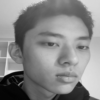

In [24]:
img_input = Image.open("./photo_to_find/input.jpeg")
img_input = img_input.convert("L")

transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])
img_input = transformation(img_input)

im = transforms.ToPILImage()(img_input)
display(im)

arra = img_input.numpy()
lis = arra.tolist()
img_input = torch.Tensor([lis])

In [25]:
# import required module
import os
import datetime
# assign directory
directory = './data/faces/all/'
 
# iterate over files in
# that directory
counter = 0
final_name_dict = {'first_person': 99}
top_10_score = 99
final_list = []
final_tensor = torch.Tensor()

pic_counter = 0
start = datetime.datetime.now()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        continue
    for filename2 in os.listdir(f):
        f2 = os.path.join(f, filename2)
        
        img_compare = Image.open(f"{f2}")
        img_compare = img_compare.convert('L')
        transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
        img_compare = transformation(img_compare)

        arra = img_compare.numpy()
        lis = arra.tolist()
        img_compare = torch.Tensor([lis])
        
        output1, output2 = model(img_input, img_compare)

        point1 = np.array((output1[0][0], output1[0][1]))
        point2 = np.array((output2[0][0], output2[0][1]))

        sum_sq = np.sum(np.square(point1 - point2))
        pic_counter += 1
        if pic_counter % 100 == 0:
            print(f'{pic_counter} pictures compared')
        if filename == 'check':
            print(sum_sq)
        
        
        if len(final_list) < 10 and sum_sq < top_10_score:
            final_list.append({f2: round(sum_sq.item(), 4)})
        if len(final_list) >= 10 and sum_sq < top_10_score:
            # find max score in the final list and get rid of it
            final_list.append({f2: round(sum_sq.item(), 4)})
            max_score = 0.00
            max_key = ''
            max_thing = {}
            for thing in final_list:
                for key in thing:
                    if thing[key] > max_score:
                        max_score = thing[key]
                        max_key = key
                        max_thing = thing
                        
            top_10_score = max_score
            final_list.remove(max_thing)
            
        # #if only want the lowest score
        # for key in final_name_dict:
        #     if final_name_dict[key] > sum_sq:
        #         final_name_dict = {f2: sum_sq} 
        #         final_tensor = img_compare


print(f'time used to search: {datetime.datetime.now() - start}') 
# top 10 lowest score
print(final_list)
min_score = 99
lowest_pic = ''
for thing in final_list:
    for key in thing:
        if thing[key] < min_score:
            lowest_pic = key
            min_score = thing[key]

img = Image.open(f"{lowest_pic}")
img.show()
print(f'lowest distance pic is {lowest_pic} at distance {min_score}')            


# if 1 lowest
#print(final_name_dict)
# for key in final_name_dict:
#     img = Image.open(f"{key}")
#     img.show()

100 pictures compared
200 pictures compared
300 pictures compared
tensor(16.2426, grad_fn=<AddBackward0>)
tensor(23.3760, grad_fn=<AddBackward0>)
tensor(17.5352, grad_fn=<AddBackward0>)
400 pictures compared
time used to search: 0:01:33.368601
[{'./data/faces/all/database/danver_1.jpg': 0.2902}, {'./data/faces/all/database/danver_3.jpg': 0.012}, {'./data/faces/all/database/aiony-haust.jpg': 0.7236}, {'./data/faces/all/s26/1.pgm': 1.7729}, {'./data/faces/all/s28/10.pgm': 2.031}, {'./data/faces/all/s12/7.pgm': 1.0677}, {'./data/faces/all/s12/4.pgm': 1.201}, {'./data/faces/all/s12/5.pgm': 1.5403}, {'./data/faces/all/s12/2.pgm': 1.2678}, {'./data/faces/all/s12/3.pgm': 1.8177}]
lowest distance pic is ./data/faces/all/database/danver_3.jpg at distance 0.012


In [ ]:
# lfw dataset, github vgg cnn
import torch.nn as nn
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
           
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load('my_model_save.pt'))
model.eval()

In [ ]:
img_input = Image.open("./photo_to_find/purnjay2.jpg")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
img_input = transformation(img_input)
im = transforms.ToPILImage()(img_input).convert("RGB")
display(im)

arra = img_input.numpy()
lis = arra.tolist()
img_input = torch.Tensor([lis])

In [ ]:
# import required module
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import datetime
# assign directory
directory = './lfw_funneled/'
 
# iterate over files in
# that directory
counter = 0
pic_counter = 0
final_name_dict = {'first_person': 99}

start = datetime.datetime.now()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        continue
    for filename2 in os.listdir(f):
        f2 = os.path.join(f, filename2)
        
        img_compare = Image.open(f"{f2}")
        transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
        img_compare = transformation(img_compare)
        
        arra = img_compare.numpy()
        lis = arra.tolist()
        img_compare = torch.Tensor([lis])
        
        output1, output2 = model(img_input, img_compare)

        point1 = np.array((output1[0][0], output1[0][1]))
        point2 = np.array((output2[0][0], output2[0][1]))

        sum_sq = np.sum(np.square(point1 - point2))
        # filename starts with 5a's to have the file always be the firstl, easy to edit
        if filename == 'aaaaa_input':
            print(sum_sq)
        pic_counter += 1
        if pic_counter % 1000 == 0:
            print(f'{pic_counter} pictures compared')
        for key in final_name_dict:
            if final_name_dict[key] > sum_sq:
                final_name_dict = {f2: sum_sq} 
        
        
print(final_name_dict)
print(datetime.datetime.now() - start)
for key in final_name_dict:
    img = Image.open(f"{key}")
    img.show()

In [ ]:
# grey github dataset, github cnn
import torch.nn as nn
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load('greymodel_save.pt'))
model.eval()

In [ ]:
img_input = Image.open("./photo_to_find/purnjay2.jpg")
img_input = img_input.convert("L")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])
img_input = transformation(img_input)
im = transforms.ToPILImage()(img_input)
display(im)

arra = img_input.numpy()
lis = arra.tolist()
img_input = torch.Tensor([lis])

In [ ]:
# import required module
import os
# assign directory
directory = './data/faces/all/'
 
# iterate over files in
# that directory
counter = 0
final_name_dict = {'first_person': 99}
final_tensor = torch.Tensor()


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        continue
    for filename2 in os.listdir(f):
        f2 = os.path.join(f, filename2)
        
        img_compare = Image.open(f"{f2}")
        img_compare = img_compare.convert('L')
        transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
        img_compare = transformation(img_compare)

        arra = img_compare.numpy()
        lis = arra.tolist()
        img_compare = torch.Tensor([lis])
        
        output1, output2 = model(img_input, img_compare)

        point1 = np.array((output1[0][0], output1[0][1]))
        point2 = np.array((output2[0][0], output2[0][1]))

        sum_sq = np.sum(np.square(point1 - point2))
        if filename == 'check':
            print(sum_sq)
        for key in final_name_dict:
            if final_name_dict[key] > sum_sq:
                final_name_dict = {f2: sum_sq} 
                final_tensor = img_compare
    
        
print(final_name_dict)
for key in final_name_dict:
    img = Image.open(f"{key}")
    img.show()